In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.rcParams['figure.figsize'] = [15, 7]
sns.color_palette()

import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer, StandardScaler

from scipy import stats
from torchmetrics.functional import pairwise_cosine_similarity, pairwise_manhattan_distance
import torch
from transformers import AutoTokenizer
import umap

from mcpt.contrastlearning.datamanager import DataManager
from mcpt.contrastlearning.datamanager import INT2LABEL as categories

In [2]:
with open('data/SemEvalEmbeddings/embeddings_untrained_en_train_dev.pickle', 'rb') as f:
    embeddings_untrained = pickle.load(f)
with open('data/SemEvalEmbeddings/embeddings_pretrained_en_train_dev.pickle', 'rb') as f:
    embeddings_pretrained = pickle.load(f)
with open('data/SemEvalEmbeddings/embeddings_trained_en_train_dev.pickle', 'rb') as f:
    embeddings_trained = pickle.load(f)

In [3]:
embeddings_untrained_normalised = Normalizer().fit_transform(embeddings_untrained)
embeddings_pretrained_normalised = Normalizer().fit_transform(embeddings_pretrained)
embeddings_trained_normalised = Normalizer().fit_transform(embeddings_trained)

In [4]:
embeddings_untrained_scaled = StandardScaler().fit_transform(embeddings_untrained)
embeddings_pretrained_scaled = StandardScaler().fit_transform(embeddings_pretrained)
embeddings_trained_scaled = StandardScaler().fit_transform(embeddings_trained)

# Desiderata
What should the embedding space look like? Calculating a sentence embedding by computing the mean of all token embeddings will inevitably discard information. Specifically, if some frames are largely represented by negative values along some dimensions this might cause interference with frames that are represented by positive values along the same dimension.

Learning a linear transformation to replace the mean assumes that we would know at what position the frames would occur.

According to _04b_ the samples are positioned along axes from the origin.

# Exploratory Analysis

In [5]:
magnitudes_untrained = embeddings_untrained.dot(embeddings_untrained.T).diagonal()
magnitudes_pretrained = embeddings_pretrained.dot(embeddings_pretrained.T).diagonal()
magnitudes_trained = embeddings_trained.dot(embeddings_trained.T).diagonal()

In [6]:
lang = 'en'
data_path = 'data/SemEval/'
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
datamanager = DataManager(
    tokenizer=tokenizer,
    data_dir=data_path,
    use_dev=True,
    languages_for_head_eval=[],
    languages_for_head_train=[lang],
    languages_for_contrastive=[lang],
)
dataset_contrastive = datamanager.get_contrastive_dataset()

In [7]:
labels = dataset_contrastive['labels'].numpy()
print(len(np.unique(labels, axis=0)), 'unique labels')

287 unique labels


In [8]:
df_magnitudes = pd.DataFrame({
    'magnitude_ut': magnitudes_untrained,
    'magnitude_pt': magnitudes_pretrained,
    'magnitude_t': magnitudes_trained,
}).join(pd.DataFrame(labels.astype(np.int32), columns=categories))
df_magnitudes.head(3)

magnitude_ut  magnitude_pt  magnitude_t  Capacity_and_resources  \
0     12.389400     30.142714    47.954346                       0   
1     11.738283     24.782324    32.033237                       0   
2     13.832531     28.430241    50.919788                       0   

   Crime_and_punishment  Cultural_identity  Economic  \
0                     0                  0         0   
1                     0                  0         1   
2                     1                  0         0   

   External_regulation_and_reputation  Fairness_and_equality  \
0                                   1                      1   
1                                   0                      0   
2                                   1                      0   

   Health_and_safety  Legality_Constitutionality_and_jurisprudence  Morality  \
0                  0                                             1         1   
1                  0                                             1         1   
2                  0                                             1         0   

   Policy_prescription_and_evaluation  Political  Public_opinion  \
0                                   0          1               0   
1                                   1          0               0   
2                                   1          1               1   

   Quality_of_life  Security_and_defense  
0                0                     0  
1                0                     1  
2                0                     0

<ipython-input-9-845690658a79>:7: UserWarning: The label '_' of <BarContainer object of 10 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, legend_labels)
<ipython-input-9-845690658a79>:7: UserWarning: The label '_' of <BarContainer object of 29 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, legend_labels)
<ipython-input-9-845690658a79>:7: UserWarning: The label '_' of <BarContainer object of 42 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, legend_labels)


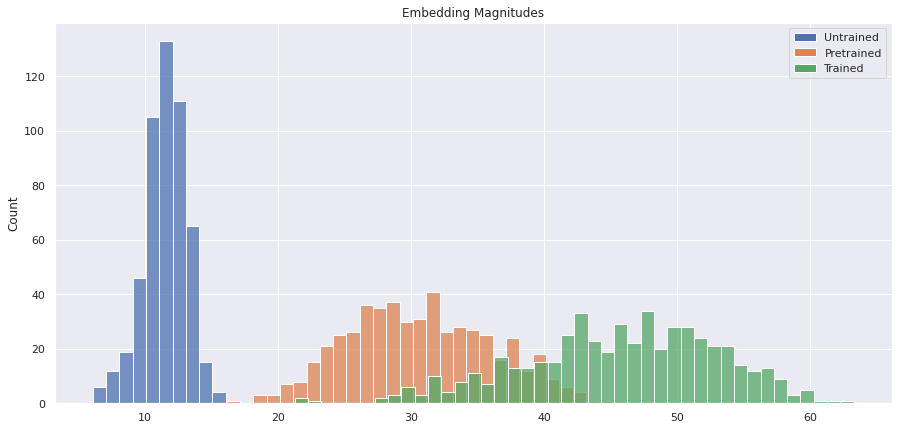

In [9]:
ax = sns.histplot(magnitudes_untrained, binwidth=1, label='Untrained')
sns.histplot(magnitudes_pretrained, binwidth=1, label='Pretrained')
sns.histplot(magnitudes_trained, binwidth=1, label='Trained')
handles, legend_labels = ax.get_legend_handles_labels()
for i in range(len(legend_labels)):
    if i % 2: legend_labels[i] = '_'
ax.legend(handles, legend_labels)
ax.set_title('Embedding Magnitudes')
plt.show()

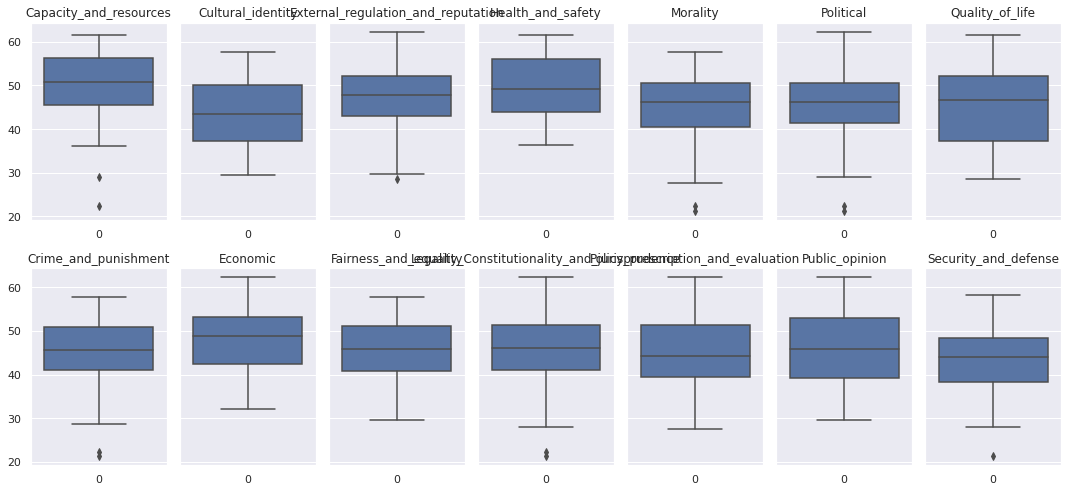

In [10]:
fig, axs = plt.subplots(2, 7, sharey=True, layout='tight')
for i, cat in enumerate(categories):
    ax = axs[i % 2, i // 2]
    sns.boxplot(magnitudes_trained[df_magnitudes[cat] == 1], ax=ax).set(title=cat)

Training generally increases the magnitudes of embeddings but there does not seem to be a difference between class distributions.

<AxesSubplot: >

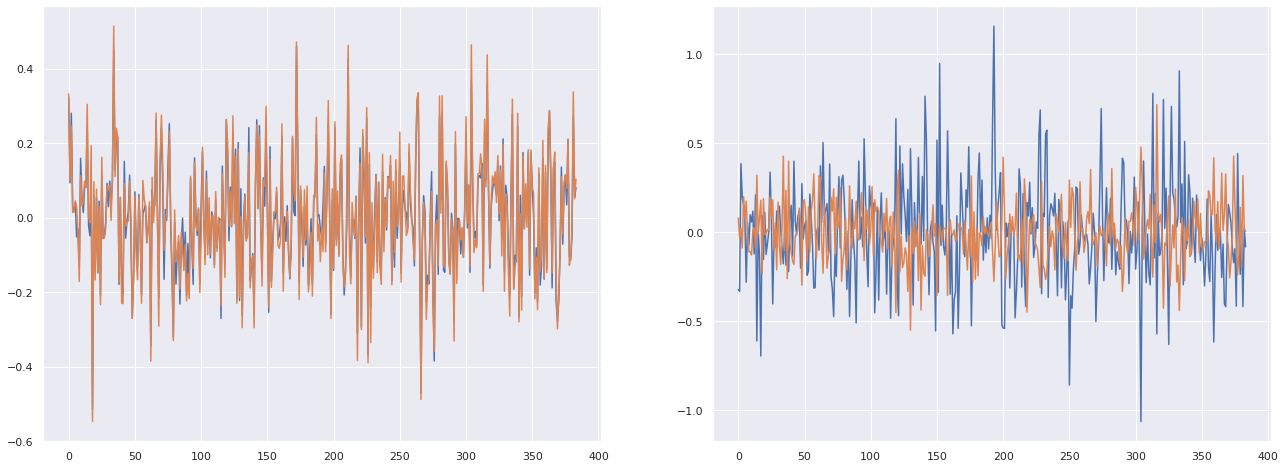

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8))
sns.lineplot(np.median(embeddings_untrained[df_magnitudes.Capacity_and_resources == 1], axis=0), ax=axs[0])
sns.lineplot(np.median(embeddings_untrained[df_magnitudes.Political == 1], axis=0), ax=axs[0])
sns.lineplot(np.median(embeddings_trained[df_magnitudes.Capacity_and_resources == 1], axis=0), ax=axs[1])
sns.lineplot(np.median(embeddings_trained[df_magnitudes.Political == 1], axis=0), ax=axs[1])

<AxesSubplot: >

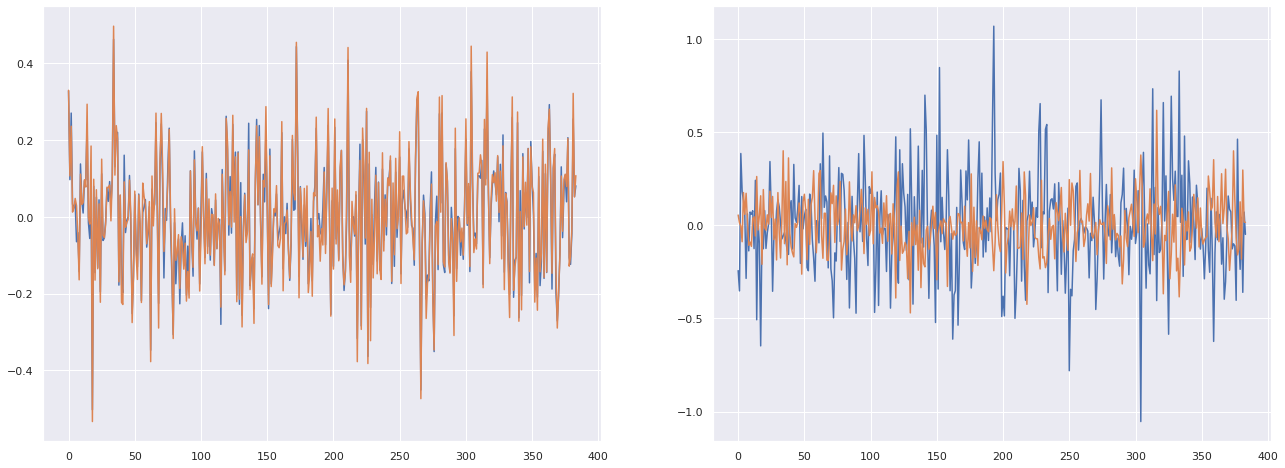

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8))
sns.lineplot(np.mean(embeddings_untrained[df_magnitudes.Capacity_and_resources == 1], axis=0), ax=axs[0])
sns.lineplot(np.mean(embeddings_untrained[df_magnitudes.Political == 1], axis=0), ax=axs[0])
sns.lineplot(np.mean(embeddings_trained[df_magnitudes.Capacity_and_resources == 1], axis=0), ax=axs[1])
sns.lineplot(np.mean(embeddings_trained[df_magnitudes.Political == 1], axis=0), ax=axs[1])

Embeddings of different classes are clearly differentiated during training.

[Text(0.5, 1.0, 'Trained')]

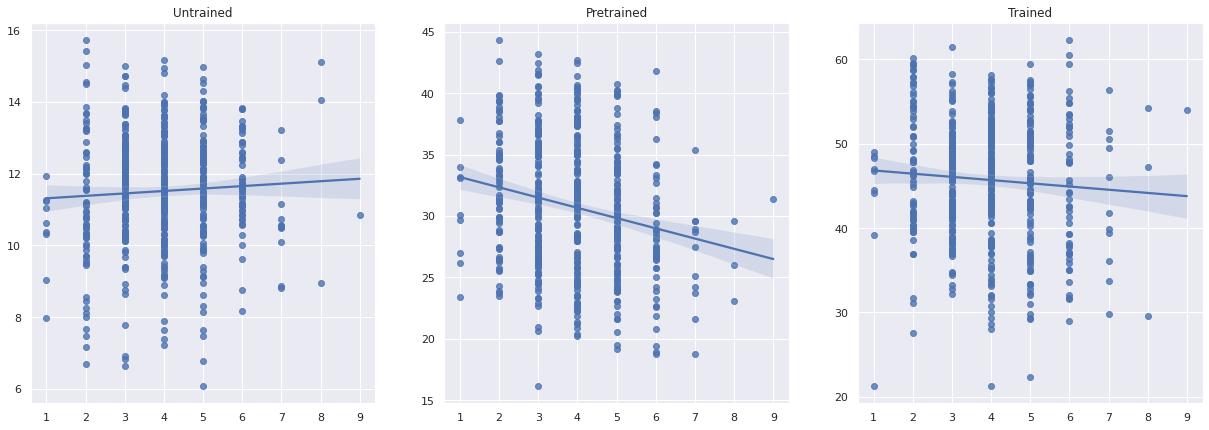

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
sns.regplot(x=labels.sum(axis=1), y=magnitudes_untrained, ax=axs[0]).set(title='Untrained')
sns.regplot(x=labels.sum(axis=1), y=magnitudes_pretrained, ax=axs[1]).set(title='Pretrained')
sns.regplot(x=labels.sum(axis=1), y=magnitudes_trained, ax=axs[2]).set(title='Trained')

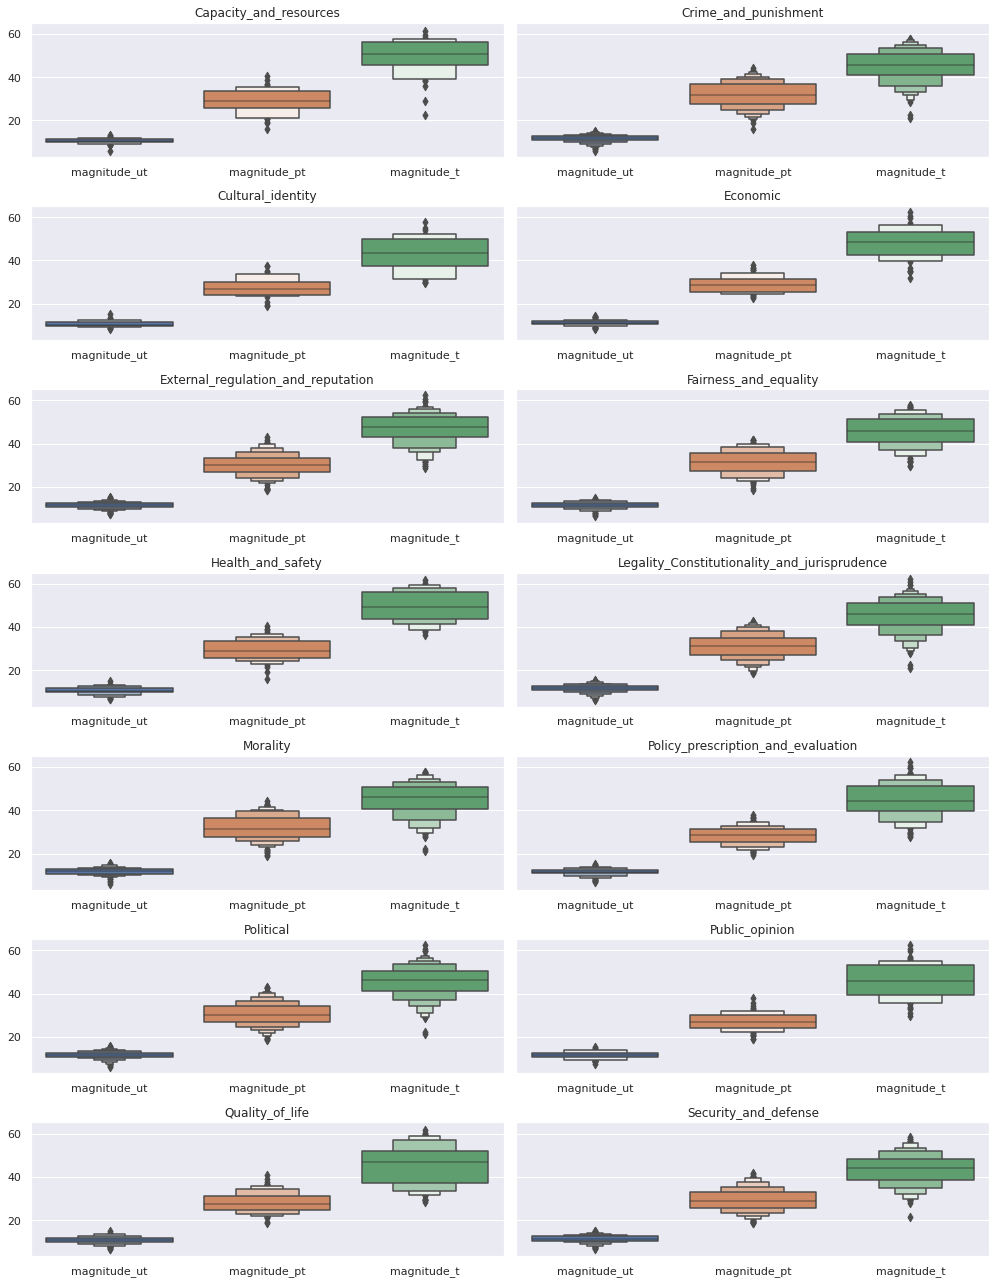

In [14]:
fig, axs = plt.subplots(7, 2, figsize=(14, 18), sharey=True, layout='tight')
for i, cat in enumerate(categories):
    row = i // 2
    col = i % 2
    sns.boxenplot(df_magnitudes[['magnitude_ut', 'magnitude_pt', 'magnitude_t']][df_magnitudes[cat] == 1], ax=axs[row, col]).set(title=cat)

# Analysis of Uniformity

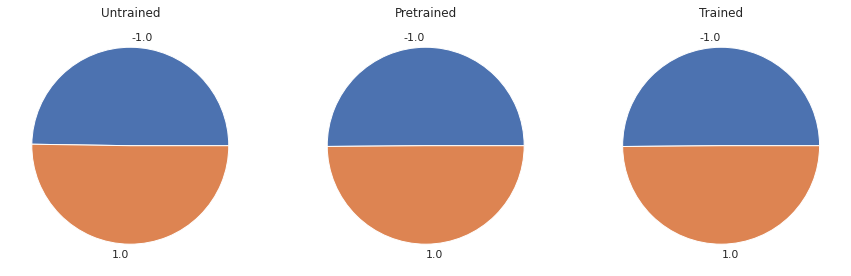

In [15]:
fig, axs = plt.subplots(1, 3)
values, counts = np.unique(np.sign(embeddings_untrained), return_counts=True)
axs[0].pie(counts, labels=values)
axs[0].set(title='Untrained')
values, counts = np.unique(np.sign(embeddings_pretrained), return_counts=True)
axs[1].pie(counts, labels=values)
axs[1].set(title='Pretrained')
values, counts = np.unique(np.sign(embeddings_trained), return_counts=True)
axs[2].pie(counts, labels=values)
axs[2].set(title='Trained')
plt.show()

0.6038646838871746


<AxesSubplot: >

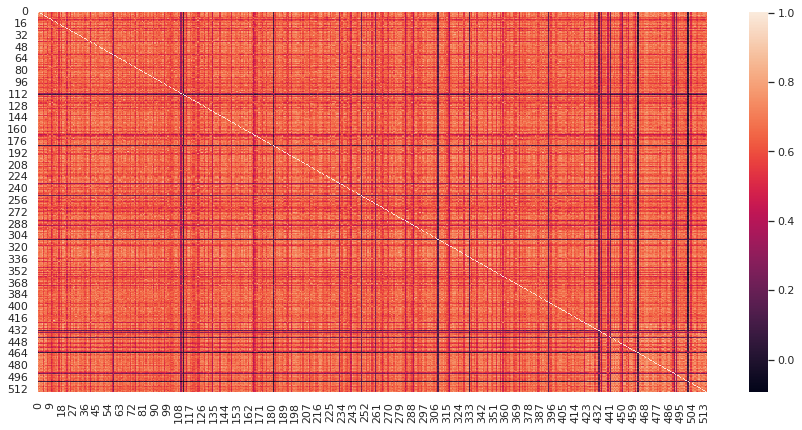

In [16]:
cov_untrained = np.cov(np.sign(embeddings_untrained))
print(np.mean(cov_untrained))
sns.heatmap(cov_untrained)

0.11234217378427921


<AxesSubplot: >

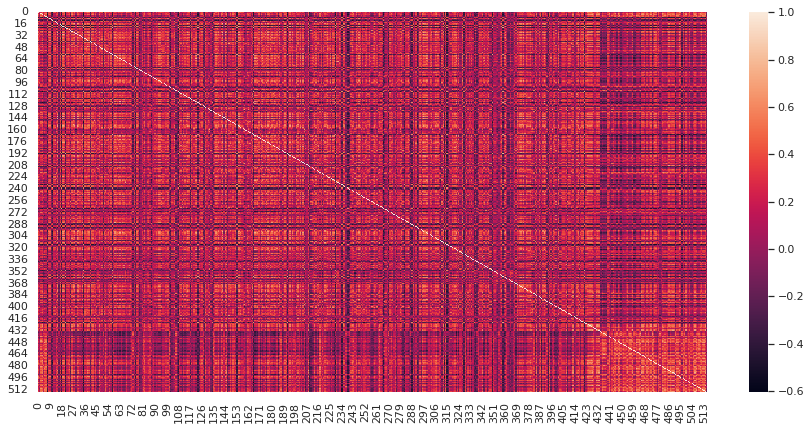

In [17]:
cov_pretrained = np.cov(np.sign(embeddings_pretrained))
print(np.mean(cov_pretrained))
sns.heatmap(cov_pretrained)

0.025872637595578656


<AxesSubplot: >

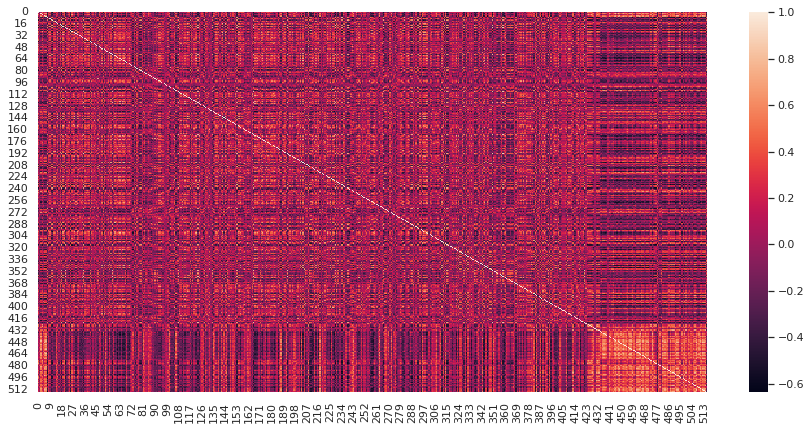

In [18]:
cov_trained = np.cov(np.sign(embeddings_trained))
print(np.mean(cov_trained))
sns.heatmap(cov_trained)

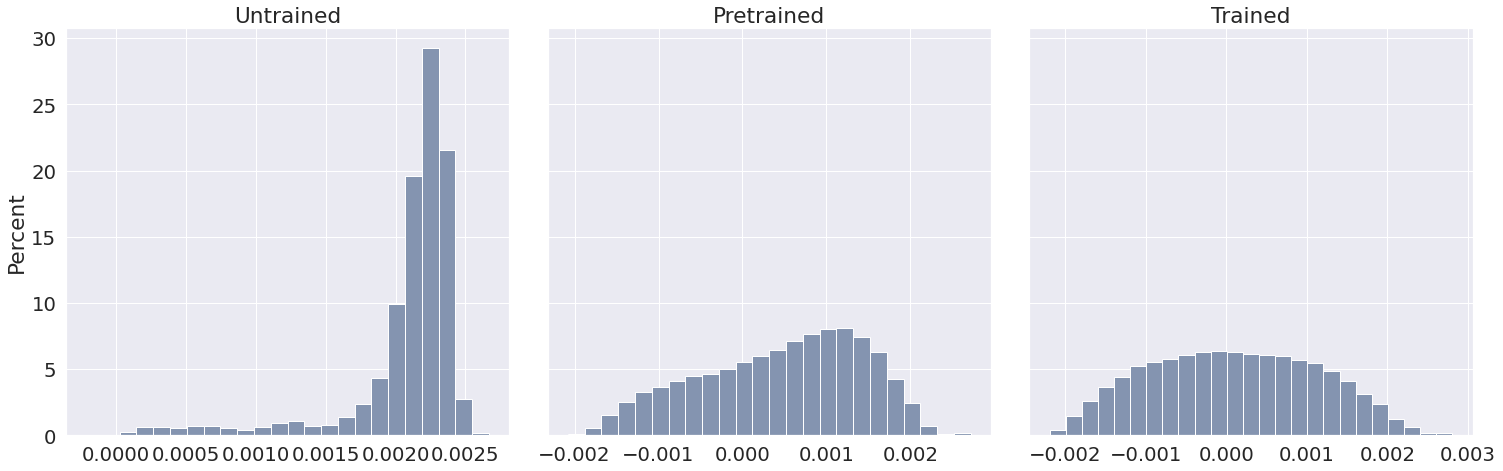

In [23]:
sns.set(font_scale=1.8)
fig, axs = plt.subplots(1, 3, figsize=(21, 7), sharey=True)
sns.histplot(np.cov(embeddings_untrained_normalised).ravel(), binwidth=0.00012, stat='percent', color='#8494b0', alpha=1., ax=axs[0]).set(title='Untrained')
sns.histplot(np.cov(embeddings_pretrained_normalised).ravel(), binwidth=0.0002, stat='percent', color='#8494b0', alpha=1., ax=axs[1]).set(title='Pretrained', ylabel='')
sns.histplot(np.cov(embeddings_trained_normalised).ravel(), binwidth=0.0002, stat='percent', color='#8494b0', alpha=1., ax=axs[2]).set(title='Trained', ylabel='')
plt.tight_layout()
#plt.savefig('figures/variance_histograms_normalised.pdf')

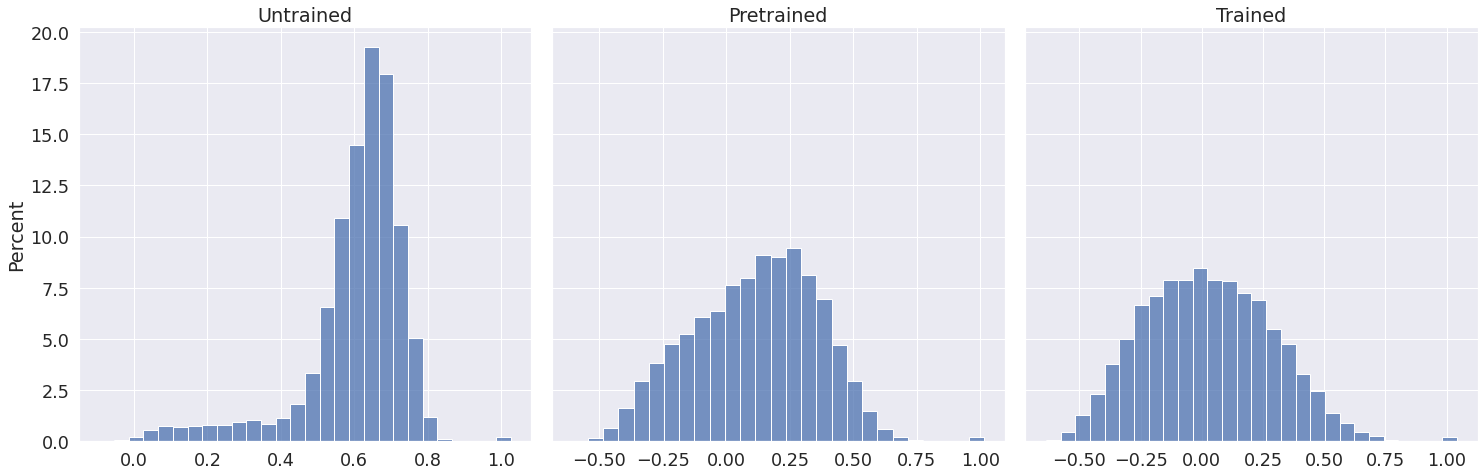

In [17]:
sns.set(font_scale=1.6)
fig, axs = plt.subplots(1, 3, figsize=(21, 7), sharey=True)
sns.histplot(cov_untrained.ravel(), binwidth=0.04, stat='percent', ax=axs[0]).set(title='Untrained')
sns.histplot(cov_pretrained.ravel(), binwidth=0.06, stat='percent', ax=axs[1]).set(title='Pretrained', ylabel='')
sns.histplot(cov_trained.ravel(), binwidth=0.06, stat='percent', ax=axs[2]).set(title='Trained', ylabel='')
plt.tight_layout()
#plt.savefig('figures/variance_histograms.svg')

# Label-Distance with Embedding Similarity

In [37]:
def plot_pairwise(embeddings, labels, num_classes=14):
    label_dists = pairwise_manhattan_distance(torch.tensor(labels))
    embeddings_dists = pairwise_cosine_similarity(torch.tensor(embeddings))
    indices = torch.tril_indices(label_dists.shape[0], label_dists.shape[1], -1).unbind()
    label_dists, embeddings_dists = label_dists[indices].cpu().detach().numpy(), embeddings_dists[indices].cpu().detach().numpy()

    regress = stats.linregress(label_dists, embeddings_dists)
    slope = regress.slope
    r_value = regress.rvalue
    print(regress.pvalue)

    order = np.arange(0, num_classes + 1, 1)
    data = pd.DataFrame({'Label Distance': label_dists, 'Embedding Similarity': embeddings_dists})
    g = sns.JointGrid(data=data, x='Label Distance', y='Embedding Similarity',
                      xlim=(order[0], order[-1]), ylim=(-1, 1), height=6, ratio=10)
    #g.fig.set_figwidth(4)
    #g.fig.set_figheight(4)
    #g.plot_joint(sns.regplot, scatter=False, color=sns.color_palette()[3], label=f'slope$={slope:.3f}$,\n$R^2={r_value**2:.3f}$')
    g.plot_joint(sns.regplot, scatter=False, color=sns.color_palette()[3], label=f'$\\beta={slope:.3f},R^2={r_value**2:.3f}$')
    #g.plot_joint(sns.boxenplot, order=order, color=sns.color_palette()[0])
    g.plot_joint(sns.boxenplot, order=order, color='#607db0', saturation=1.)
    sns.histplot(label_dists, ax=g.ax_marg_x, binwidth=1, binrange=(order[0]-0.5, order[-1]-0.5), color='#8494b0', alpha=1.)
    sns.histplot(y=embeddings_dists, ax=g.ax_marg_y, binrange=(-1, 1), bins=50, color='#8494b0', alpha=1.)
    #g.plot_marginals(sns.histplot)
    g.ax_joint.legend(loc='lower right', fontsize=17)

1.8285235571669265e-125


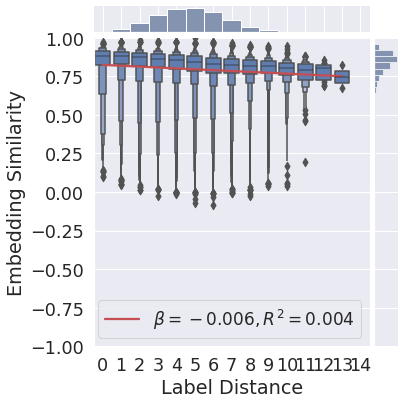

In [39]:
sns.set(font_scale=1.6)
plot_pairwise(embeddings_untrained, labels)
#plt.savefig('figures/label_embedding_untrained.pdf')

0.0


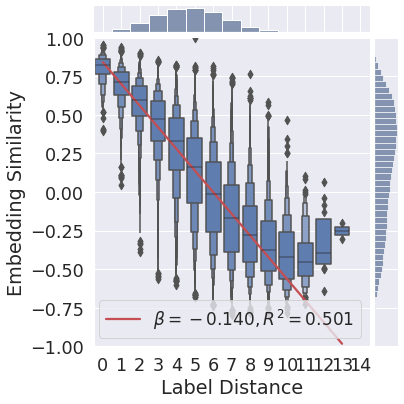

In [40]:
sns.set(font_scale=1.6)
plot_pairwise(embeddings_pretrained, labels)
#plt.savefig('figures/label_embedding_pretrained.pdf')

0.0


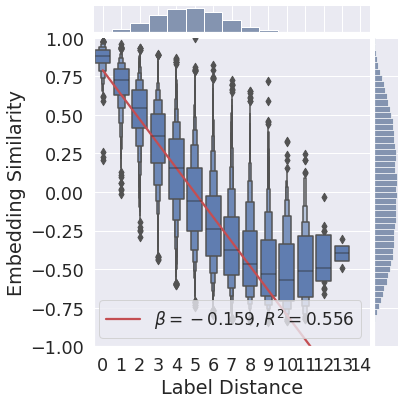

In [41]:
sns.set(font_scale=1.6)
plot_pairwise(embeddings_trained, labels)
#plt.savefig('figures/label_embedding_trained.pdf')

# Token Embeddings

In [22]:
with open('data/SemEvalEmbeddings/token_embeddings_trained.pickle', 'rb') as f:
    token_embeddings = pickle.load(f)
token_embeddings.shape

(516, 512, 384)

In [23]:
classifier = MLPClassifier(hidden_layer_sizes=(256), max_iter=10000)
classifier.fit(embeddings_trained, labels)

MLPClassifier(hidden_layer_sizes=256, max_iter=10000)

['External_regulation_and_reputation'
 'Legality_Constitutionality_and_jurisprudence'
 'Policy_prescription_and_evaluation' 'Political' 'Public_opinion']


<AxesSubplot: >

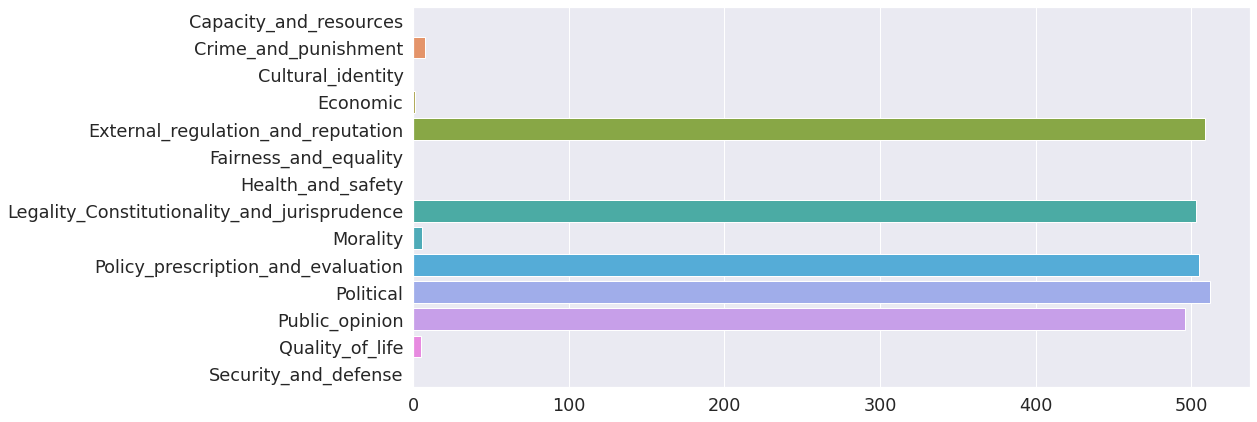

In [24]:
idx = 6
sample_one_token_predictions = classifier.predict(token_embeddings[idx])
print(np.array(categories)[labels[idx] == 1])
sns.barplot(x=np.sum(sample_one_token_predictions, axis=0), y=categories, orient='horizontal')

Once the model has been fine-tuned averaging the individual token embeddings is not even really needed since most tokens would result in a prediction of all of the present frames.

Legality_Constitutionality_and_jurisprudence


<AxesSubplot: ylabel='Count'>

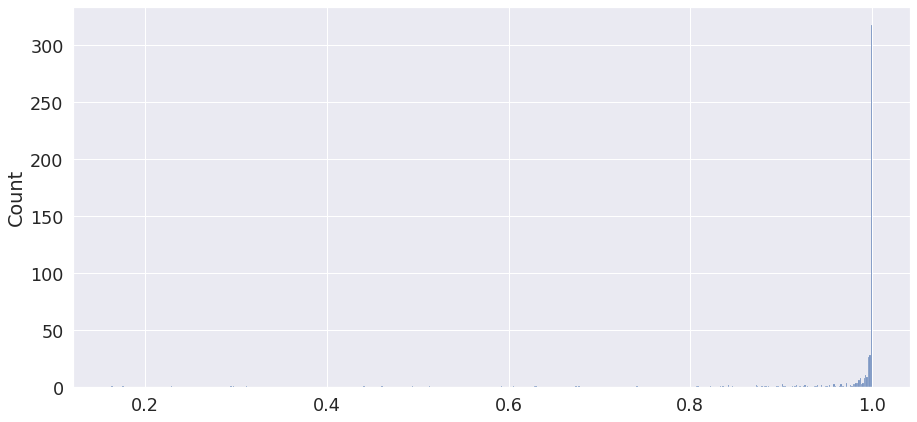

In [25]:
frame_idx = 7
print(categories[frame_idx])
sample_one_token_probs = classifier.predict_proba(token_embeddings[idx])
sns.histplot(sample_one_token_probs.T[frame_idx])

In [26]:
tokens = dataset_contrastive['input_ids'][idx]
tokenizer.decode(tokens)

'<s> Bill Maher says he doesn\'t need Mueller report to know Trump is a traitor \'because he has a TV\' Bill Maher has said he doesn\'t need the Robert Mueller report to know President Donald Trump is a traitor \'because he has a TV\'. Speaking on his Friday night show the Real Time host said: \'I must say, I don\'t think it looks good. No further indictments, which means not Don Jr., even after the "I love it" memo, really? Not Jared, not Manafort or Stone for working with the Russians. \'Did the Democrats put too must trust in the Mueller report? Because I don\'t need the Mueller report to know he\'s a traitor. I have a TV.\' Maher was joined by a panel of Democratic Rep. Eric Swalwell, GOP pollster Kristen Soltis Anderson and former Deputy Assistant Secretary for Defense for Russia Evelyn Farkas. After labeling Trump a traitor the audience the clapped in approval. Swalwell agreed, saying \'yes, if you have a TV or a Twitter account you\'ve already seen obstruction of justice\'. Real

In [27]:
max_frame_token_idxs = np.argsort(sample_one_token_probs.T[frame_idx])[::-1]
tokenizer.decode(tokens.numpy()[max_frame_token_idxs])

'justice happen justice a a attorney lawyer allowed a allowed ja the investigation asion the it what to a a a a of file a the a a restrict it have aludict be to of of to to criminal the that make the a approments which the to the testifystruct have ob its thatize ob to don to not the the.struct is that was isments Don finding account and to,mo agreed report on outing doesn.?pped the aion toun reportdict to have to there" ofca vera, in report any the or orously with is by that in important and doesncity, not. and,, subbe, in no in people\' by, up or has\'\' otherare way\' for the. they\'pros have forve.\' Javeing,\' me or.\' of. as other, shoulduse trai with\'be and Jres. not put, was\'report,.s night.yes would\'\' there,But\' col. reportil., is.\'\'\'was\'s doesn but come gone. Friday if their Special has I Co yesAnd report has even,. hasd\'\' "ed Fridayster\' the Twitter Defense\'means has for has Not the said are edit here nots\' workingt the beuse account not\'the saidt Twitter? \'b

# Importance of Embedding Dimensions

In [28]:
classifier_untrained = OneVsRestClassifier(LogisticRegression())
classifier_untrained.fit(embeddings_untrained, labels)
classifier_untrained.score(embeddings_untrained, labels)

0.1821705426356589

<AxesSubplot: >

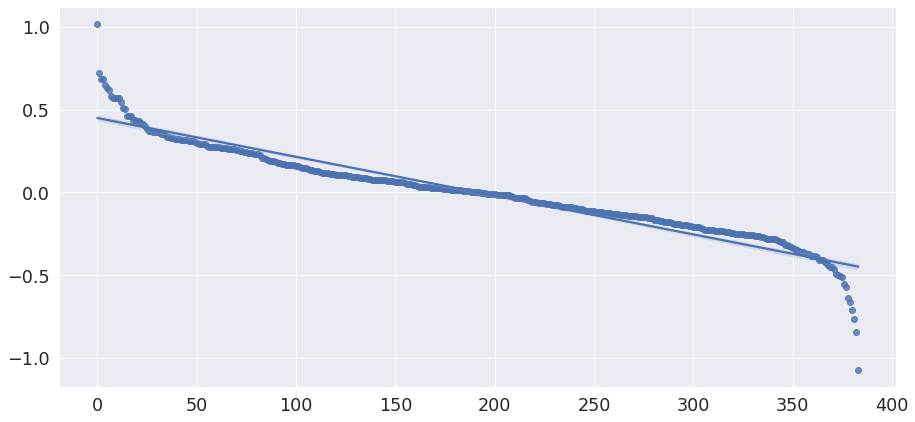

In [29]:
coefficients = classifier_untrained.estimators_[0].coef_[0]
order = np.argsort(coefficients)[::-1]
sns.regplot(x=np.arange(len(coefficients)), y=coefficients[order])

<AxesSubplot: ylabel='Count'>

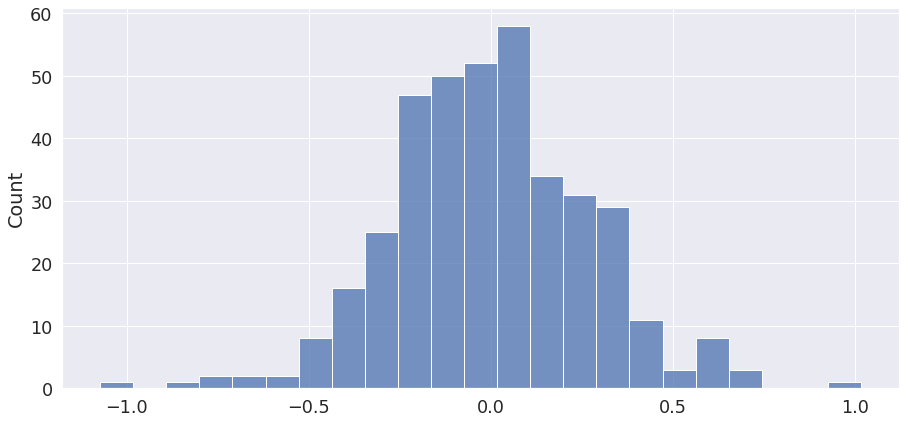

In [30]:
sns.histplot(coefficients)

In [31]:
classifier_pretrained = OneVsRestClassifier(LogisticRegression())
classifier_pretrained.fit(embeddings_pretrained, labels)
classifier_pretrained.score(embeddings_pretrained, labels)

0.9341085271317829

<AxesSubplot: >

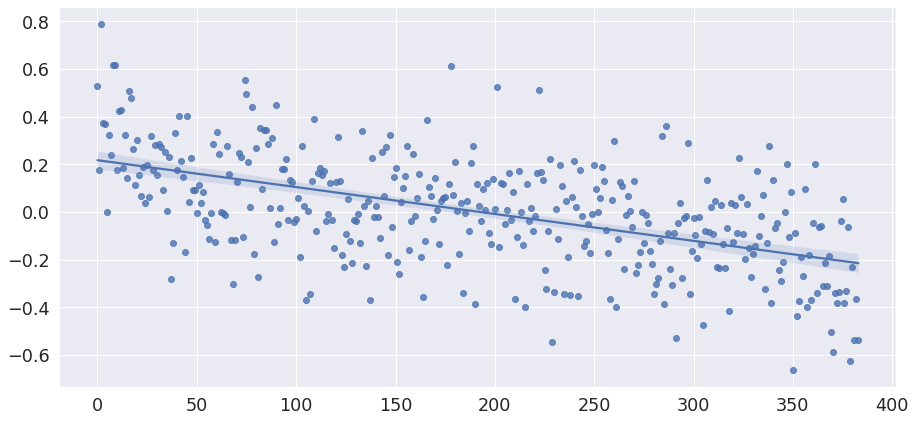

In [32]:
coefficients = classifier_pretrained.estimators_[0].coef_[0]
sns.regplot(x=np.arange(len(coefficients)), y=coefficients[order])

<AxesSubplot: ylabel='Count'>

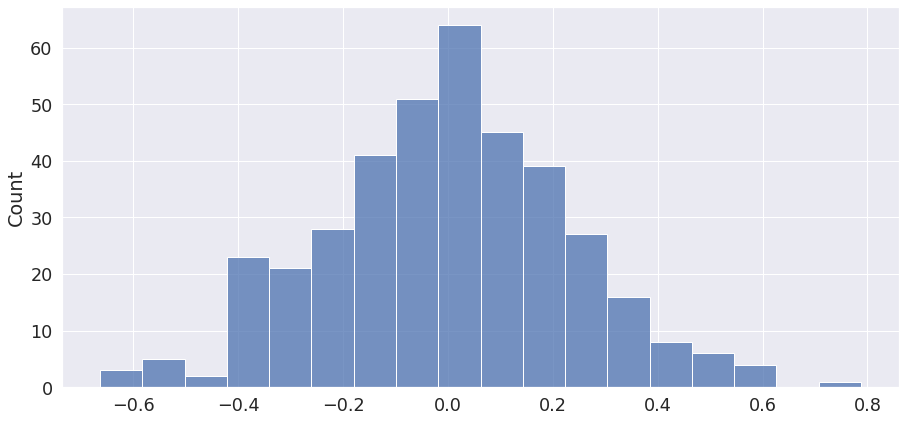

In [33]:
sns.histplot(coefficients)

In [34]:
classifier_trained = OneVsRestClassifier(LogisticRegression())
classifier_trained.fit(embeddings_trained, labels)
classifier_trained.score(embeddings_trained, labels)

0.998062015503876

<AxesSubplot: >

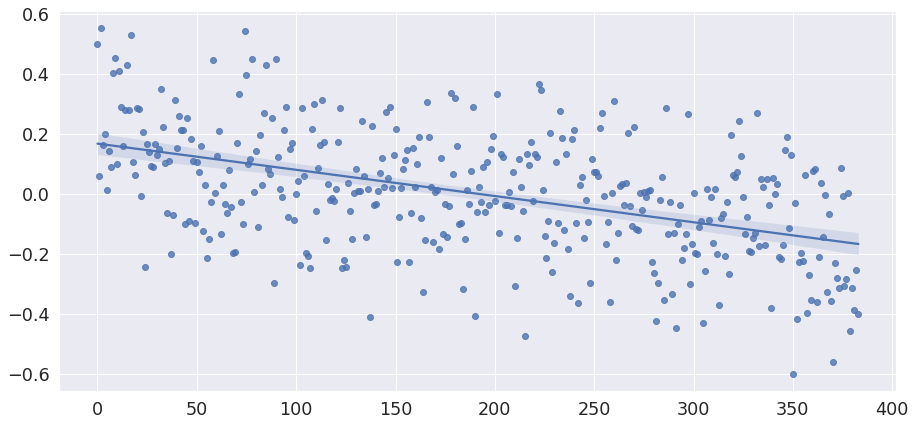

In [35]:
coefficients = classifier_trained.estimators_[0].coef_[0]
sns.regplot(x=np.arange(len(coefficients)), y=coefficients[order])

<AxesSubplot: ylabel='Count'>

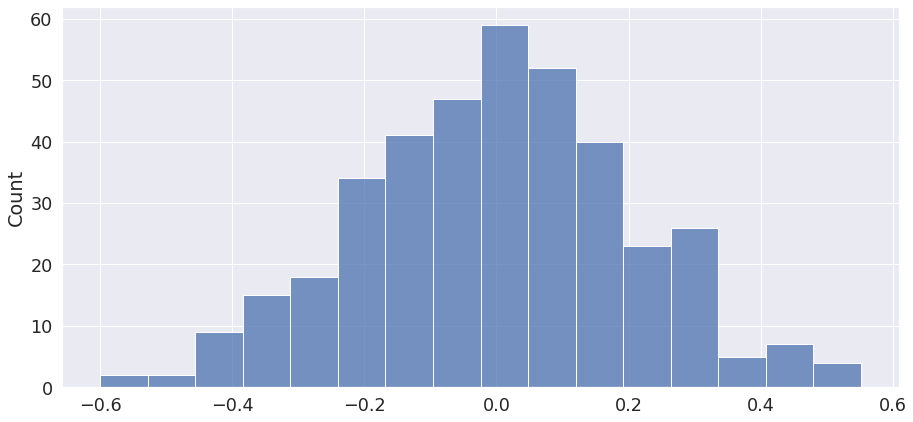

In [36]:
sns.histplot(classifier_trained.estimators_[0].coef_[0])

# Clustering

In [43]:
reducer = umap.UMAP()
embeddings_trained_scaled_umap = reducer.fit_transform(embeddings_trained_scaled)
embeddings_trained_scaled_umap.shape

(516, 2)

<AxesSubplot: >

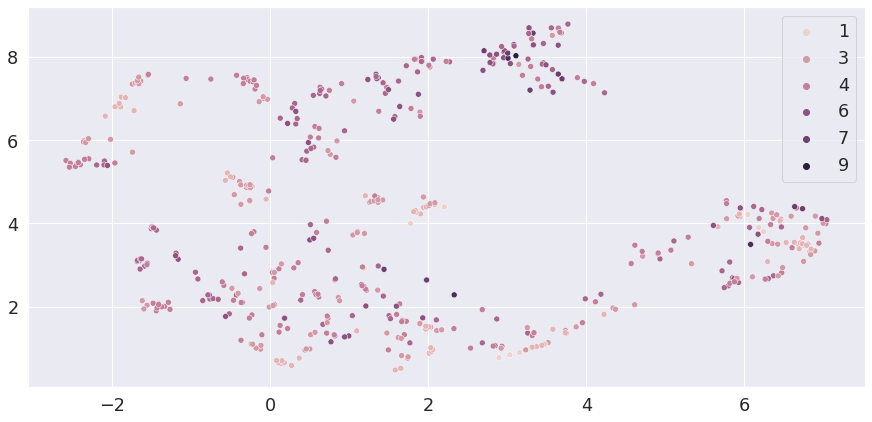

In [46]:
sns.scatterplot(
    x=embeddings_trained_scaled_umap[:,0],
    y=embeddings_trained_scaled_umap[:,1],
    hue=np.sum(labels, axis=1, dtype=np.int32),
)

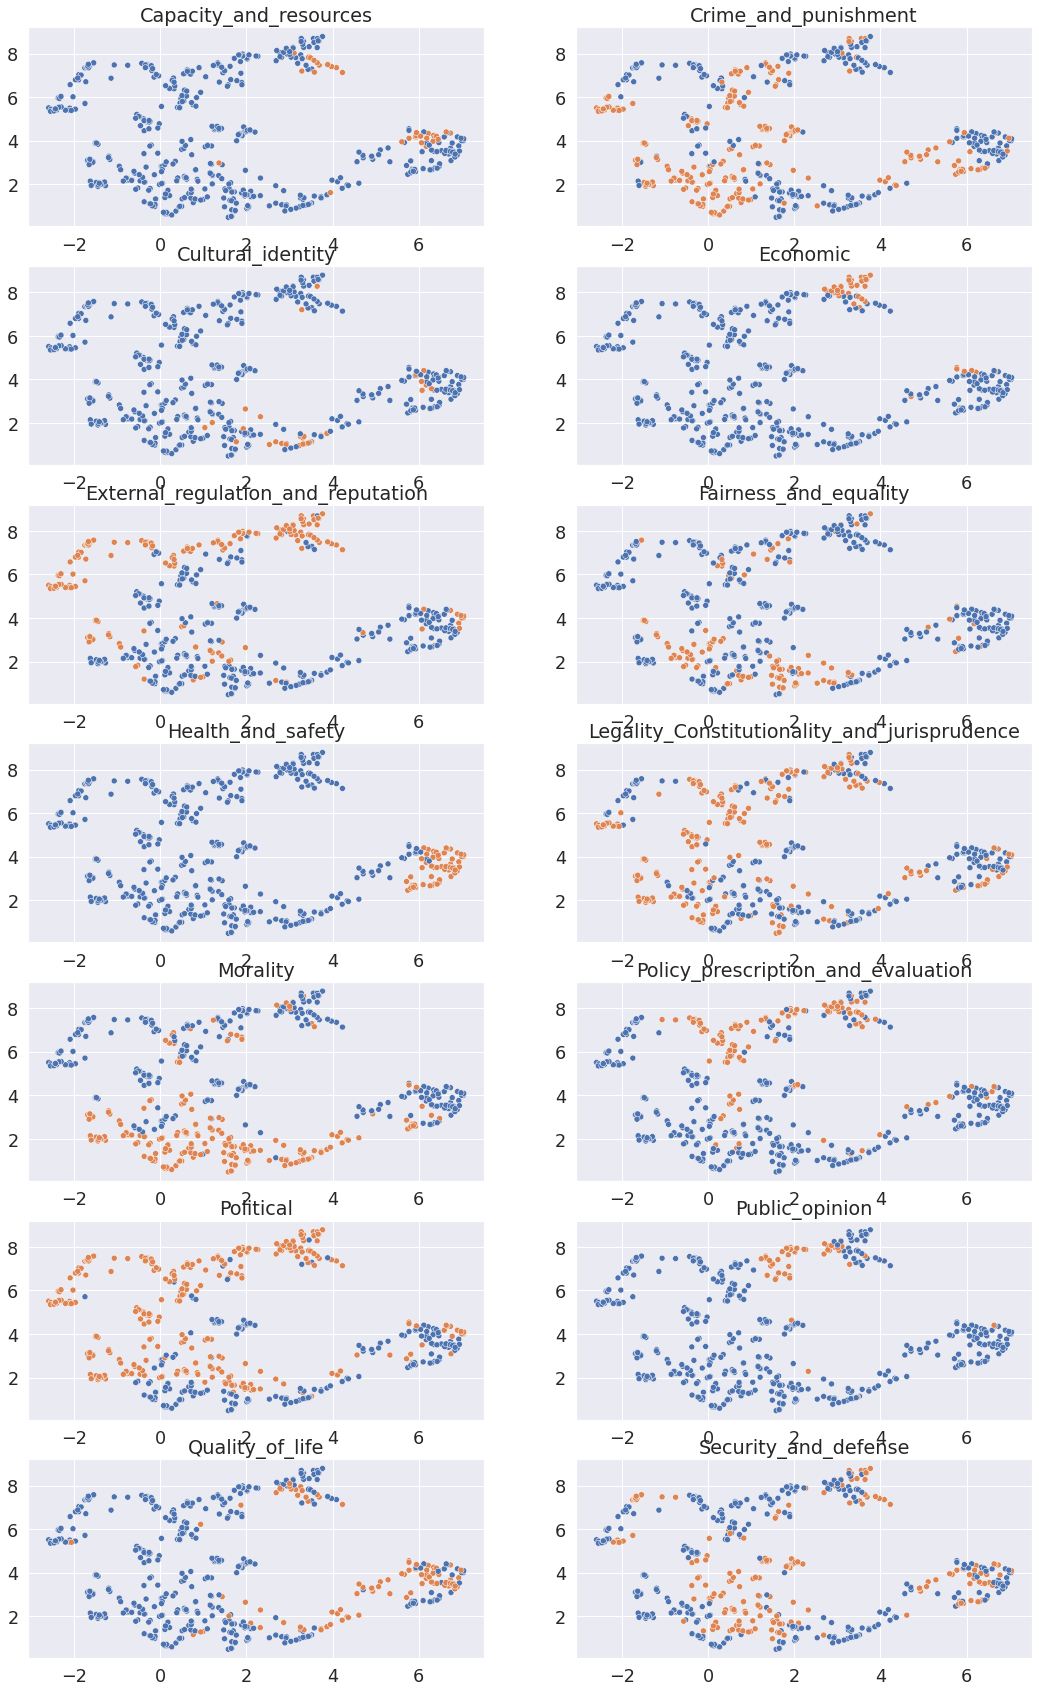

In [49]:
fig, axs = plt.subplots(7, 2, figsize=(18, 30))
for i in range(14):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    sns.scatterplot(
        x=embeddings_trained_scaled_umap[:,0],
        y=embeddings_trained_scaled_umap[:,1],
        hue=df_magnitudes[categories[i]],
        legend=False,
        ax=ax
    ).set(title=categories[i])